<a href="https://colab.research.google.com/github/lym0405/simple_homepage/blob/main/%EC%95%8C%EA%B3%A0%EB%A6%AC%EB%93%AC_%EA%B0%9C%EC%9D%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q seaborn

In [4]:
pip install yfinance pandas matplotlib seaborn

In [5]:
import os, json
from datetime import datetime
import numpy as nd
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# 한 셀에서 실행: yfinance에서 다운로드(신세계 + S&P500) -> 안전히 Adj Close 추출 -> CSV 저장
import os
import pandas as pd
import numpy as np
import yfinance as yf

OUT_DIR = "./data"
os.makedirs(OUT_DIR, exist_ok=True)

tickers_map = {"SHINSEGAE": "004170.KS", "SP500": "^GSPC"}
START = "2024-08-29"
END   = "2025-08-29"

def safe_sanitize_dataframe(df):
    # flatten MultiIndex columns if any (join with underscore)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join([str(part) for part in col if part is not None and str(part)!='']) for col in df.columns]
        # e.g. "Adj Close_^GSPC", "Close_^GSPC", ...
    # Ensure datetime index
    try:
        df.index = pd.to_datetime(df.index)
    except Exception:
        df.index = pd.to_datetime(df.index.astype(str), errors='coerce')
    # Coerce numeric-ish columns to numeric (vectorized)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def get_adj_series_from_df(df, ticker_label):
    """
    Given a df returned by yfinance for a single ticker, return a 1-d pd.Series
    that is the adjusted close for that ticker.
    Ticker_label is the yahoo ticker (e.g. '^GSPC' or '004170.KS') or our friendly name.
    This function handles:
      - MultiIndex columns like ('Adj Close','^GSPC')
      - Flattened columns like 'Adj Close_^GSPC'
      - normal single-level columns 'Adj Close' or 'Close'
    """
    # 1) If MultiIndex originally (we didn't flatten yet), try tuple selection
    if isinstance(df.columns, pd.MultiIndex):
        # try exact tuple
        tup = ('Adj Close', ticker_label)
        if tup in df.columns:
            return df[tup].copy()
        # try ('Adj Close', ) slice
        try:
            adj_all = df.xs('Adj Close', axis=1, level=0)
            # adj_all may be Series (single ticker) or DataFrame (many tickers)
            if isinstance(adj_all, pd.Series):
                return adj_all.copy()
            # if DataFrame, try to find the column matching ticker_label
            for col in adj_all.columns:
                if str(col) == str(ticker_label) or str(col).endswith(str(ticker_label)):
                    return adj_all[col].copy()
            # else return first column (fallback)
            return adj_all.iloc[:,0].copy()
        except Exception:
            pass

    # 2) If columns flattened to 'Adj Close_^GSPC' or similar
    # construct candidates
    candidates = [
        f"Adj Close_{ticker_label}",
        f"Adj Close^{ticker_label}",
        f"AdjClose_{ticker_label}",
        f"Adj Close {ticker_label}",
        'Adj Close', 'adj close', 'adjclose', 'Close', 'close'
    ]
    for cand in candidates:
        if cand in df.columns:
            ser = df[cand]
            # if this is dataframe/object, try to coerce to series
            if isinstance(ser, pd.Series):
                return ser.copy()
            # if unexpected, try first column
            if isinstance(ser, pd.DataFrame):
                return ser.iloc[:,0].copy()

    # 3) As a last resort: try to find any column name that contains 'adj' and 'close'
    for c in df.columns:
        lc = str(c).lower()
        if 'adj' in lc and 'close' in lc:
            return df[c].copy()

    # 4) If nothing found, try 'Close'
    if 'Close' in df.columns:
        return df['Close'].copy()

    # If still nothing, raise to debug upstream
    raise KeyError("Could not find an Adj Close (or Close) series in this dataframe. Columns: " + ", ".join(map(str, df.columns[:20])))

# ---- Main loop: download each ticker, extract adj series, combine ----
adj_series_list = []
for friendly, tk in tickers_map.items():
    print("Downloading", friendly, tk)
    df = yf.download(tk, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        raise RuntimeError(f"No data for {tk}")
    # Keep a raw copy
    raw_path = os.path.join(OUT_DIR, f"{friendly}_raw.csv")
    # Save raw (safe sanitize before saving to make CSV readable)
    df_safe = safe_sanitize_dataframe(df.copy())
    df_safe.to_csv(raw_path)
    print("  saved raw:", raw_path)

    # Now attempt to get Adj Close series using robust function
    try:
        # Note: pass the Yahoo ticker when checking tuple keys; but friendly is used as column name later
        ser = get_adj_series_from_df(df, tk)
    except KeyError as e:
        # try again after flattening columns (for safety)
        df_flat = safe_sanitize_dataframe(df.copy())
        try:
            ser = get_adj_series_from_df(df_flat, tk)
        except Exception as e2:
            print("ERROR extracting Adj Close for", tk)
            print("df.columns:", df.columns)
            raise

    # rename the series to friendly name and append
    ser = ser.rename(friendly)
    adj_series_list.append(ser)

# Concatenate (align on dates), reindex to business days and forward-fill
adj_df = pd.concat(adj_series_list, axis=1)
bidx = pd.date_range(start=adj_df.index.min(), end=adj_df.index.max(), freq='B')
adj_df = adj_df.reindex(bidx).ffill()
adj_csv = os.path.join(OUT_DIR, "prices_adj.csv")
adj_df.to_csv(adj_csv)
print("Saved combined adj CSV:", adj_csv)
print(adj_df.info())
print(adj_df.head())


  saved raw: ./data/SHINSEGAE_raw.csv
  saved raw: ./data/SP500_raw.csv
Saved combined adj CSV: ./data/prices_adj.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2024-08-29 to 2025-08-28
Freq: B
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SHINSEGAE  261 non-null    float64
 1   SP500      261 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB
None
                SHINSEGAE        SP500
2024-08-29  145401.906250  5591.959961
2024-08-30  145983.515625  5648.399902
2024-09-02  148116.078125  5648.399902
2024-09-03  152284.265625  5528.930176
2024-09-04  147243.671875  5520.069824


In [7]:
# === Compute SMAs, detect MA crosses, plot, and save outputs ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

OUT = "./data"
os.makedirs(OUT, exist_ok=True)

# Use existing adj_df if in memory otherwise load from CSV
try:
    adj_df
except NameError:
    adj_df = pd.read_csv(os.path.join(OUT, "prices_adj.csv"), index_col=0, parse_dates=True)

# ensure DatetimeIndex and business-day reindex (safety)
if not isinstance(adj_df.index, pd.DatetimeIndex):
    adj_df.index = pd.to_datetime(adj_df.index)
bidx = pd.date_range(start=adj_df.index.min(), end=adj_df.index.max(), freq='B')
adj_df = adj_df.reindex(bidx).ffill()
adj_df = adj_df.loc[adj_df.index.min():adj_df.index.max()]  # keep full range

# 1) compute SMAs per column
windows = (5, 20, 60)
df_sma = adj_df.copy()
for col in adj_df.columns:
    for w in windows:
        df_sma[f"{col}_SMA_{w}"] = adj_df[col].rolling(window=w, min_periods=1).mean()

# save CSV with SMA
sma_path = os.path.join(OUT, "prices_with_sma.csv")
df_sma.to_csv(sma_path)
print("Saved:", sma_path)

# 2) helper: find crosses (returns lists of timestamps)
def find_crosses(series_short, series_long):
    diff = series_short - series_long
    sign = np.sign(diff)
    golden = series_short.index[(sign > 0) & (sign.shift(1) <= 0)]
    dead   = series_short.index[(sign < 0) & (sign.shift(1) >= 0)]
    return list(golden), list(dead)

# detect for SHINSEGAE: SMA_5 vs SMA_20 and SMA_20 vs SMA_60
stock = "SHINSEGAE"
g5_20, d5_20 = find_crosses(df_sma[f"{stock}_SMA_5"], df_sma[f"{stock}_SMA_20"])
g20_60, d20_60 = find_crosses(df_sma[f"{stock}_SMA_20"], df_sma[f"{stock}_SMA_60"])

# save crosses to CSV
rows = []
for d in g5_20:
    rows.append({"date": pd.to_datetime(d).date(), "type":"golden", "pair": f"{stock} 5/20"})
for d in d5_20:
    rows.append({"date": pd.to_datetime(d).date(), "type":"dead", "pair": f"{stock} 5/20"})
for d in g20_60:
    rows.append({"date": pd.to_datetime(d).date(), "type":"golden", "pair": f"{stock} 20/60"})
for d in d20_60:
    rows.append({"date": pd.to_datetime(d).date(), "type":"dead", "pair": f"{stock} 20/60"})

crosses_df = pd.DataFrame(rows).sort_values("date")
crosses_path = os.path.join(OUT, "ma_crosses_shinsegae.csv")
crosses_df.to_csv(crosses_path, index=False)
print("Saved:", crosses_path)

# 3) post-cross returns (horizons 10 & 20 business days)
def post_cross_returns(df, cross_dates, price_col, horizons=(10,20)):
    out_rows = []
    # normalize cross_dates to Timestamps
    tss = [pd.to_datetime(d) for d in cross_dates]
    for ts in tss:
        pos = df.index.searchsorted(ts)
        if pos >= len(df):
            continue
        start_idx = pos
        for h in horizons:
            end_idx = start_idx + h
            if end_idx < len(df):
                p0 = df[price_col].iloc[start_idx]
                p1 = df[price_col].iloc[end_idx]
                if pd.isna(p0) or pd.isna(p1):
                    continue
                ret = float(p1 / p0 - 1.0)
                out_rows.append({"cross_date": df.index[start_idx].date(), "horizon": h, "return": ret})
    if not out_rows:
        return pd.DataFrame(columns=["horizon","mean","std","count"])
    out = pd.DataFrame(out_rows)
    agg = out.groupby("horizon")["return"].agg(["mean","std","count"]).reset_index()
    return agg

golden_agg = post_cross_returns(df_sma, g5_20, price_col=stock, horizons=(10,20))
dead_agg   = post_cross_returns(df_sma, d5_20, price_col=stock, horizons=(10,20))
golden_agg.to_csv(os.path.join(OUT,"golden_post_returns_5_20.csv"), index=False)
dead_agg.to_csv(os.path.join(OUT,"dead_post_returns_5_20.csv"), index=False)
print("Saved post-cross return summaries (5/20).")

# 4) plotting (normalized, and price+SMA for stock)
def safe_plot_price_sma(df_with_sma, symbol_col, out_png):
    dates = df_with_sma.index
    date_nums = mdates.date2num(dates.to_pydatetime())
    # bar width scalar
    if len(date_nums) >= 2:
        bar_w = float(np.median(np.diff(date_nums))) * 0.6
    else:
        bar_w = 0.8

    fig, ax = plt.subplots(2,1, figsize=(11,7), gridspec_kw={"height_ratios":[3,1]}, sharex=True)
    ax0, ax1 = ax
    ax0.plot(dates, df_with_sma[symbol_col], label=f"{symbol_col}", linewidth=1.1)
    for w in windows:
        col_name = f"{symbol_col}_SMA_{w}"
        if col_name in df_with_sma.columns:
            ax0.plot(dates, df_with_sma[col_name], label=f"SMA {w}", linewidth=0.9)
    ax0.legend(loc="upper left", fontsize=8)
    ax0.grid(True, alpha=0.3)

    # no volume available in prices_adj; put placeholder text
    ax1.text(0.5, 0.5, "Volume not included in adj CSV", transform=ax1.transAxes, ha='center', va='center')
    ax1.set_ylabel("Volume")
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close(fig)
    print("Saved:", out_png)

# normalized comparison plot
norm = adj_df / adj_df.iloc[0] * 100
norm_png = os.path.join(OUT, "normalized_shinsegae_sp500.png")
fig, ax = plt.subplots(figsize=(11,5))
for c in norm.columns:
    ax.plot(norm.index, norm[c], label=c)
ax.legend()
ax.set_title("Normalized prices (base=100)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(norm_png)
plt.close()
print("Saved:", norm_png)

# stock price + sma plot
plot_png = os.path.join(OUT, "SHINSEGAE_price_sma.png")
safe_plot_price_sma(df_sma, "SHINSEGAE", plot_png)

# 5) summary JSON
summary = {
    "stock": {"ticker": "SHINSEGAE", "last_date": str(adj_df.index[-1].date()), "last_val": float(adj_df["SHINSEGAE"].iloc[-1])},
    "index": {"ticker": "SP500", "last_date": str(adj_df.index[-1].date()), "last_val": float(adj_df["SP500"].iloc[-1])},
    "cross_counts": {"golden_5_20": len(g5_20), "dead_5_20": len(d5_20), "golden_20_60": len(g20_60), "dead_20_60": len(d20_60)}
}
with open(os.path.join(OUT,"summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print("Saved: summary.json")

# Done - list outputs
print("\nAll outputs in:", OUT)
print(sorted([p for p in os.listdir(OUT) if p.endswith(".csv") or p.endswith(".png") or p.endswith(".json")]))


Saved: ./data/prices_with_sma.csv
Saved: ./data/ma_crosses_shinsegae.csv
Saved post-cross return summaries (5/20).
Saved: ./data/normalized_shinsegae_sp500.png
Saved: ./data/SHINSEGAE_price_sma.png
Saved: summary.json

All outputs in: ./data
['SHINSEGAE_price_sma.png', 'SHINSEGAE_raw.csv', 'SP500_raw.csv', 'dead_post_returns_5_20.csv', 'golden_post_returns_5_20.csv', 'ma_crosses_shinsegae.csv', 'normalized_shinsegae_sp500.png', 'prices_adj.csv', 'prices_with_sma.csv', 'summary.json']


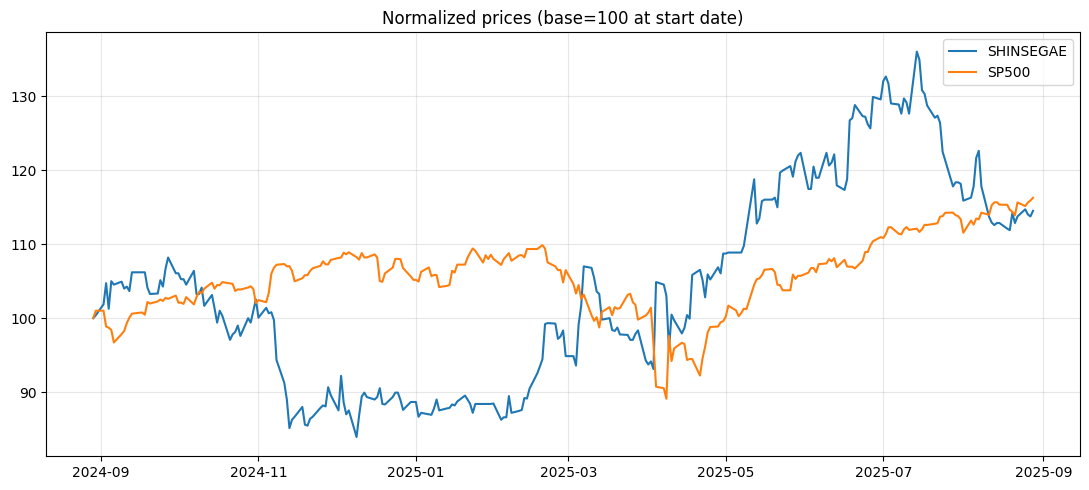

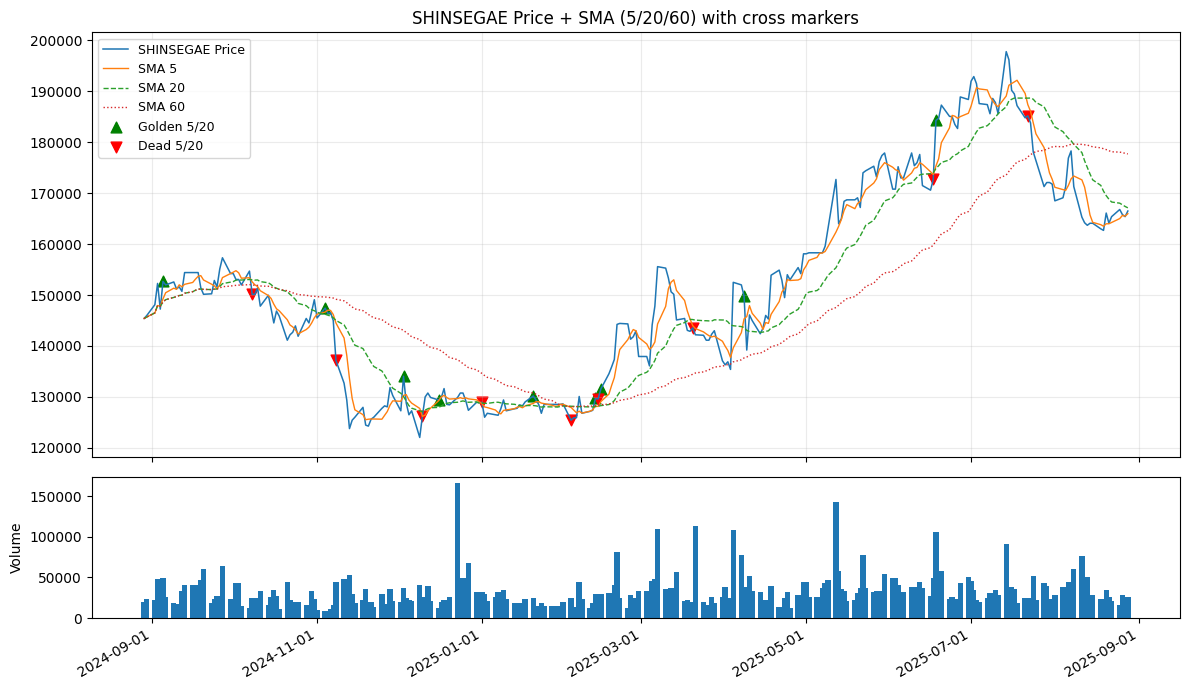

Last golden 5/20 crosses (most recent 5): [Timestamp('2025-01-20 00:00:00'), Timestamp('2025-02-12 00:00:00'), Timestamp('2025-02-14 00:00:00'), Timestamp('2025-04-08 00:00:00'), Timestamp('2025-06-18 00:00:00')]
Last dead 5/20 crosses (most recent 5): [Timestamp('2025-02-03 00:00:00'), Timestamp('2025-02-13 00:00:00'), Timestamp('2025-03-20 00:00:00'), Timestamp('2025-06-17 00:00:00'), Timestamp('2025-07-22 00:00:00')]


In [8]:
# 한 셀에 붙여넣고 실행 — inline으로 그래프 보여줌
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_DIR = "./data"
adj_path = os.path.join(DATA_DIR, "prices_adj.csv")
sma_path = os.path.join(DATA_DIR, "prices_with_sma.csv")
raw_stock_path = os.path.join(DATA_DIR, "SHINSEGAE_raw.csv")  # volume source if available

# 0) load data (either from memory or CSV)
try:
    df_sma  # if already in memory from earlier cell
except NameError:
    if os.path.exists(sma_path):
        df_sma = pd.read_csv(sma_path, index_col=0, parse_dates=True)
    else:
        # fallback: build sma from adj csv
        if os.path.exists(adj_path):
            adj_df = pd.read_csv(adj_path, index_col=0, parse_dates=True)
            df_sma = adj_df.copy()
            for col in adj_df.columns:
                for w in (5,20,60):
                    df_sma[f"{col}_SMA_{w}"] = adj_df[col].rolling(window=w, min_periods=1).mean()
        else:
            raise FileNotFoundError("No prices_with_sma.csv or prices_adj.csv found in ./data")

# ensure index is datetime
df_sma.index = pd.to_datetime(df_sma.index)

# load adj_df if needed for normalized plot
if 'adj_df' not in globals():
    if os.path.exists(adj_path):
        adj_df = pd.read_csv(adj_path, index_col=0, parse_dates=True)
        adj_df.index = pd.to_datetime(adj_df.index)
    else:
        # construct from df_sma (strip SMA cols)
        adj_cols = [c for c in df_sma.columns if not c.endswith(tuple(['_SMA_5','_SMA_20','_SMA_60']))]
        adj_df = df_sma[[c for c in df_sma.columns if not '_SMA_' in c]].copy()

# Try to load raw stock to get Volume
volume_series = None
if os.path.exists(raw_stock_path):
    try:
        raw_stock = pd.read_csv(raw_stock_path, index_col=0, parse_dates=True)
        # look for a 'Volume' column; if multi-level names, try to find any column containing 'Volume'
        candidate = None
        for c in raw_stock.columns:
            if 'volume' in str(c).lower():
                candidate = c
                break
        if candidate is not None:
            volume_series = raw_stock[candidate].astype(float).reindex(df_sma.index).ffill()
    except Exception as e:
        print("Could not read raw stock Volume:", e)

# ---------- Plot 1: Normalized comparison ----------
plt.figure(figsize=(11,5))
norm = adj_df / adj_df.iloc[0] * 100
for c in norm.columns:
    plt.plot(norm.index, norm[c], label=c)
plt.title("Normalized prices (base=100 at start date)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Plot 2: SHINSEGAE price + SMA with cross markers ----------
stock = "SHINSEGAE"
if stock not in df_sma.columns:
    # try fallback: maybe column named differently, pick first non-SMA column
    non_sma = [c for c in df_sma.columns if not "_SMA_" in c]
    if len(non_sma) > 0:
        stock = non_sma[0]
    else:
        raise KeyError("No stock column found in df_sma")

dates = df_sma.index
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(12,7), gridspec_kw={"height_ratios":[3,1]}, sharex=True)

ax0.plot(dates, df_sma[stock], label=f"{stock} Price", linewidth=1.1)
for w, col_style in zip((5,20,60), ['-', '--', ':']):
    col_name = f"{stock}_SMA_{w}"
    if col_name in df_sma.columns:
        ax0.plot(dates, df_sma[col_name], label=f"SMA {w}", linestyle=col_style, linewidth=1.0)

# compute and mark 5/20 crosses (golden/dead)
def find_crosses(series_short, series_long):
    diff = series_short - series_long
    sign = np.sign(diff)
    golden = series_short.index[(sign > 0) & (sign.shift(1) <= 0)]
    dead   = series_short.index[(sign < 0) & (sign.shift(1) >= 0)]
    return list(golden), list(dead)

if f"{stock}_SMA_5" in df_sma.columns and f"{stock}_SMA_20" in df_sma.columns:
    g5, d5 = find_crosses(df_sma[f"{stock}_SMA_5"], df_sma[f"{stock}_SMA_20"])
    # plot markers
    ax0.scatter(g5, df_sma.loc[g5, stock], marker='^', color='green', s=60, label='Golden 5/20')
    ax0.scatter(d5, df_sma.loc[d5, stock], marker='v', color='red', s=60, label='Dead 5/20')
else:
    g5 = d5 = []

ax0.legend(loc='upper left', fontsize=9)
ax0.set_title(f"{stock} Price + SMA (5/20/60) with cross markers")
ax0.grid(alpha=0.25)

# volume plot if available
if volume_series is not None:
    ax1.bar(dates, volume_series.reindex(dates).fillna(0), width=2, align='center')
    ax1.set_ylabel("Volume")
else:
    ax1.text(0.5, 0.5, "No Volume data available", ha='center', va='center', transform=ax1.transAxes)
    ax1.set_ylabel("Volume")

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# ---------- Optional: show the last few cross dates ----------
print("Last golden 5/20 crosses (most recent 5):", g5[-5:] if g5 else [])
print("Last dead 5/20 crosses (most recent 5):", d5[-5:] if d5 else [])


Detected price column: SHINSEGAE_price, rows: 261

=== Summary (per window) ===
window=5: bias_abs_median=1957.23, resid_std_median=2032.66, roll_std_median=2040.24, trend_strength_median=0.226056
window=20: bias_abs_median=4309.44, resid_std_median=4363.09, roll_std_median=4891.54, trend_strength_median=0.0819349
window=60: bias_abs_median=4559.73, resid_std_median=5757.15, roll_std_median=8724.42, trend_strength_median=0.0398518

=== Tuning top 6 (window=20) ===
 decay  ewma  trend_m     resid_m      roll_m      bias_m    score
  0.80   NaN 0.096003 3235.980585 4891.544276 1915.577512 0.000014
  0.80   3.0 0.091780 3821.557990 4891.544276 2366.193347 0.000012
  0.90   NaN 0.086615 3813.089705 4891.544276 3057.388693 0.000010
  0.80   5.0 0.087937 4105.649384 4891.544276 2853.895484 0.000010
  0.92   NaN 0.087544 3913.531259 4891.544276 3360.783470 0.000010
  0.90   3.0 0.086019 4166.324741 4891.544276 3544.616126 0.000009


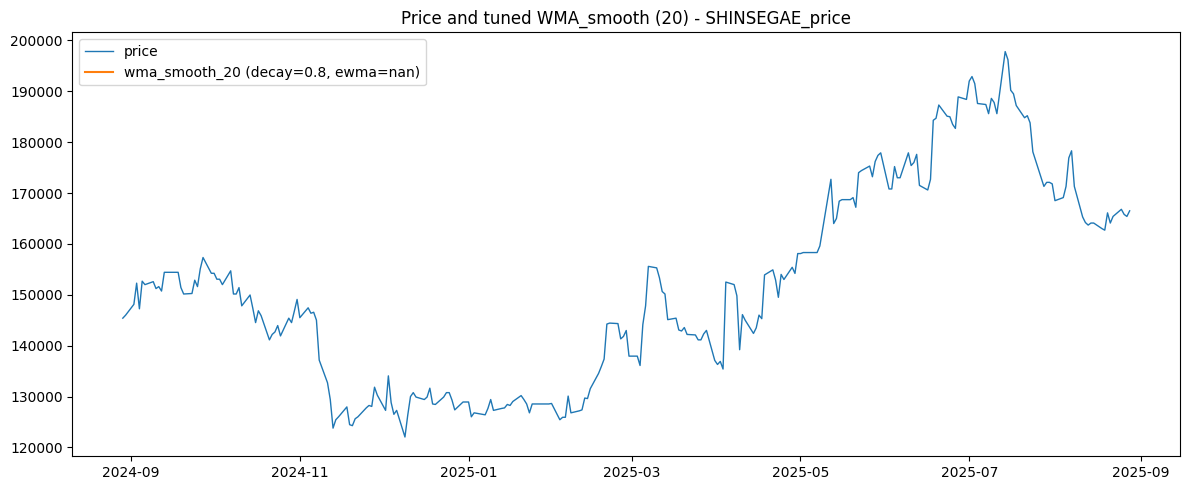

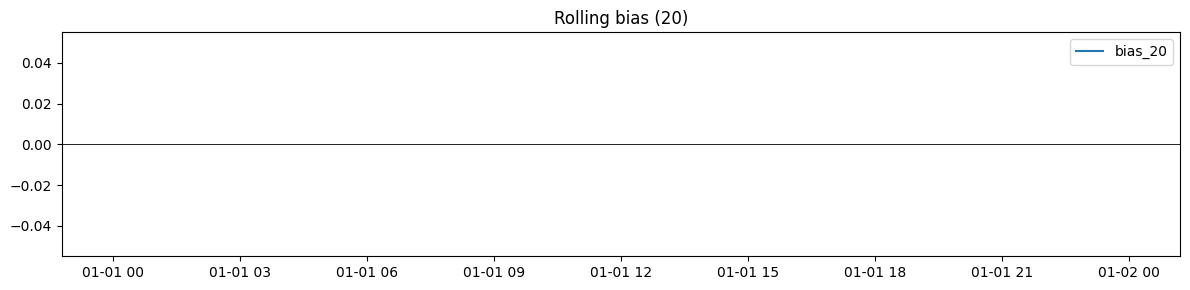

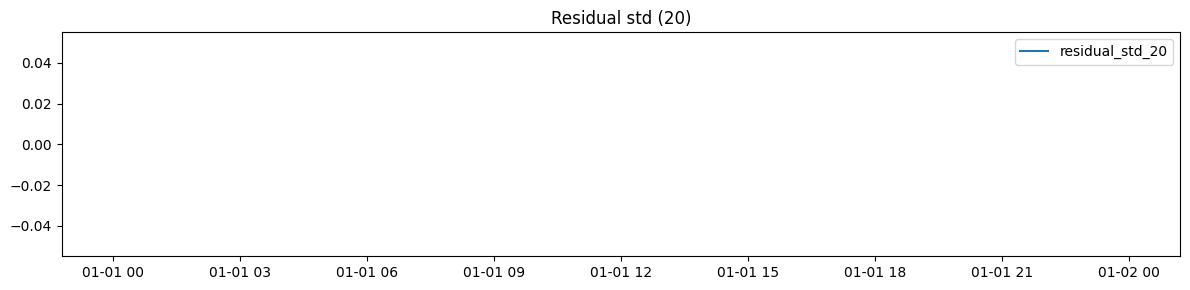


Saved tuning table to: /mnt/data/tune_results.csv
Saved best wma_smooth series to: /mnt/data/best_wma_smooth_20_SHINSEGAE_price.csv

Done. 필요하면 (1) 더 촘촘한 그리드로 튜닝, (2) SP500 비교, (3) 신호 생성/백테스트를 바로 해줄게.


In [33]:
# bias_and_variance_tuning.py
# 사용법: 그냥 이 파일을 실행하면 /mnt/data/price_df.csv를 자동으로 불러와 분석합니다.
# 필요 패키지: pandas, numpy, sklearn, scipy, matplotlib
# (예: pip install pandas numpy scikit-learn scipy matplotlib)

import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# -----------------------
# 1) 데이터 로드 및 price 컬럼 자동 감지
# -----------------------
CSV_PATH = "price_df.csv"  # 파일 위치 (필요하면 바꿔주세요)

if 'price_df' in globals() and isinstance(globals()['price_df'], pd.DataFrame):
    df = globals()['price_df']
else:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"{CSV_PATH} 파일을 찾을 수 없습니다. price_df 변수로 DataFrame을 전달하거나 파일을 업로드해주세요.")
    df = pd.read_csv(CSV_PATH)

# 날짜 인덱스 시도
date_col = None
for c in df.columns:
    if c.lower() in ('date','datetime','time','timestamp'):
        date_col = c; break
if date_col is None:
    # heuristic: object 컬럼에 '-' 포함하는 경우
    for c in df.columns:
        if df[c].dtype == object and df[c].astype(str).str.contains('-').any():
            date_col = c; break
if date_col is not None:
    try:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.set_index(date_col).sort_index()
    except Exception:
        pass

# 가격 칼럼 후보 탐색
candidates = ['Adj Close','adj_close','Adj_Close','Close','close','ClosePrice','adjclose','price','close_price',
              'SHINSEGAE_price','SP500_price']
price_col = next((c for c in candidates if c in df.columns), None)
if price_col is None:
    # numeric 컬럼 중 이름에 'close' 포함하거나, 가장 마지막 numeric 컬럼을 사용
    numeric_cols = list(df.select_dtypes(include=[np.number]).columns)
    price_col = next((c for c in numeric_cols if 'close' in c.lower()), None)
    if price_col is None and numeric_cols:
        price_col = numeric_cols[-1]

if price_col is None:
    raise ValueError("price 컬럼을 찾지 못했습니다. CSV의 컬럼명을 알려주시거나 price_df에 종가 컬럼을 포함시켜 주세요.")

price = df[price_col].astype(float).copy()
price = price.sort_index()

print(f"Detected price column: {price_col}, rows: {len(price)}")

# -----------------------
# 2) 유틸 함수들 (WMA, EWMA, SG, rolling slope)
# -----------------------
def weighted_ma(series, window, decay=0.95):
    vals = series.values
    n = len(vals)
    out = np.full(n, np.nan)
    if window <= 0:
        return pd.Series(out, index=series.index)
    for i in range(window-1, n):
        wv = vals[i-window+1:i+1]
        k = np.arange(window-1, -1, -1)  # oldest..recent
        w = decay ** k
        if np.isnan(wv).any():
            out[i] = np.nan
        else:
            out[i] = (wv * w).sum() / w.sum()
    return pd.Series(out, index=series.index)

def ewma(series, span):
    if span is None:
        return series
    return series.ewm(span=span, adjust=False).mean()

def sg_smooth(series, window_length=7, polyorder=2):
    if window_length is None:
        return series
    # ensure odd window and <= length
    wl = int(window_length)
    if wl % 2 == 0: wl += 1
    if wl >= len(series):
        return series.fillna(method='ffill').fillna(method='bfill')
    tmp = series.fillna(method='ffill').fillna(method='bfill').values
    smooth = savgol_filter(tmp, wl, polyorder, mode='interp')
    return pd.Series(smooth, index=series.index)

def rolling_slope(series, window):
    if window <= 1:
        return pd.Series(np.nan, index=series.index)
    n = len(series)
    slopes = np.full(n, np.nan)
    X = np.arange(window).reshape(-1,1)
    lr = LinearRegression()
    vals = series.values
    for i in range(window-1, n):
        y = vals[i-window+1:i+1]
        if np.isnan(y).any():
            slopes[i] = np.nan
            continue
        lr.fit(X, y.reshape(-1,1))
        slopes[i] = float(lr.coef_[0])
    return pd.Series(slopes, index=series.index)

# -----------------------
# 3) 핵심 계산 함수 (MA, bias, variance, trend)
# -----------------------
def compute_all_metrics(series, windows=[5,20,60], decay=0.92, ewma_span=None, sg_window=None):
    results = {}
    for w in windows:
        sma = series.rolling(window=w).mean()
        wma = weighted_ma(series, window=w, decay=decay)
        wma_s = ewma(wma, span=ewma_span) if ewma_span is not None else wma
        if sg_window is not None:
            wma_s = sg_smooth(wma_s, window_length=sg_window, polyorder=2)
        roll_std = series.rolling(window=w).std()
        roll_var = series.rolling(window=w).var()
        residual = series - wma_s
        residual_std = residual.rolling(window=w).std()
        bias = residual.rolling(window=w).mean()  # rolling mean of residuals
        slope = rolling_slope(wma_s, window=w)
        trend_strength = slope / (roll_std + 1e-12)
        results[w] = {
            'sma': sma, 'wma_smooth': wma_s, 'roll_std': roll_std, 'roll_var': roll_var,
            'residual': residual, 'residual_std': residual_std, 'bias': bias,
            'bias_abs_median': float(bias.abs().median(skipna=True)),
            'bias_median': float(bias.median(skipna=True)),
            'resid_std_median': float(residual_std.median(skipna=True)),
            'roll_std_median': float(roll_std.median(skipna=True)),
            'slope_median': float(slope.median(skipna=True)),
            'trend_strength_median': float(trend_strength.abs().median(skipna=True))
        }
    return results

# -----------------------
# 4) 튜닝 그리드 (bias + variance 고려한 score)
# -----------------------
def tune_grid(series, window=20, decays=[0.8,0.9,0.92,0.95,0.98], ewma_spans=[None,3,5,8],
              w_var=0.5, w_bias=0.7):
    rows = []
    for d in decays:
        for s in ewma_spans:
            m = compute_all_metrics(series, windows=[window], decay=d, ewma_span=s)[window]
            trend_m = m['trend_strength_median']
            resid = m['resid_std_median']
            roll = m['roll_std_median']
            bias = m['bias_abs_median']
            # score: 클수록 좋음 (trend 크게 살리고 residual/roll/bias 작게)
            score = (trend_m) / (resid + w_var * roll + w_bias * bias + 1e-12)
            rows.append({'decay': d, 'ewma': s, 'trend_m': trend_m, 'resid_m': resid, 'roll_m': roll, 'bias_m': bias, 'score': score})
    df = pd.DataFrame(rows).sort_values('score', ascending=False).reset_index(drop=True)
    return df

# -----------------------
# 5) 실행: 기본 파라미터로 측정 및 튜닝
# -----------------------
windows = [5,20,60]
default_decay = 0.92
default_ewma = 5
default_sg = None  # Savitzky-Golay 윈도우 사용하려면 (예: 7)

metrics = compute_all_metrics(price, windows=windows, decay=default_decay, ewma_span=default_ewma, sg_window=default_sg)
tune_df = tune_grid(price, window=20)

# 출력 요약
print("\n=== Summary (per window) ===")
for w in windows:
    m = metrics[w]
    print(f"window={w}: bias_abs_median={m['bias_abs_median']:.6g}, resid_std_median={m['resid_std_median']:.6g}, roll_std_median={m['roll_std_median']:.6g}, trend_strength_median={m['trend_strength_median']:.6g}")

print("\n=== Tuning top 6 (window=20) ===")
print(tune_df.head(6).to_string(index=False))

# -----------------------
# 6) 시각화: price, best WMA_smooth(20), bias(20), residual_std(20)
# -----------------------
best = tune_df.iloc[0]
best_decay = best['decay']
best_ewma = best['ewma']

best_metrics = compute_all_metrics(price, windows=[20], decay=best_decay, ewma_span=best_ewma, sg_window=default_sg)[20]

plt.figure(figsize=(12,5))
plt.plot(price.index, price, label='price', linewidth=1)
plt.plot(best_metrics['wma_smooth'].index, best_metrics['wma_smooth'], label=f'wma_smooth_20 (decay={best_decay}, ewma={best_ewma})', linewidth=1.5)
plt.title(f'Price and tuned WMA_smooth (20) - {price_col}')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(best_metrics['bias'].index, best_metrics['bias'], label='bias_20')
plt.axhline(0, color='k', linewidth=0.6)
plt.title('Rolling bias (20)'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(best_metrics['residual_std'].index, best_metrics['residual_std'], label='residual_std_20')
plt.title('Residual std (20)'); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------
# 7) 결과 저장 (CSV)
# -----------------------
OUT_DIR = "/mnt/data"
os.makedirs(OUT_DIR, exist_ok=True)
tune_csv = os.path.join(OUT_DIR, "tune_results.csv")
tune_df.to_csv(tune_csv, index=False)
best_wma_csv = os.path.join(OUT_DIR, f"best_wma_smooth_20_{price_col}.csv")
best_metrics['wma_smooth'].to_csv(best_wma_csv, header=[f"wma_smooth_20_{price_col}"])

print(f"\nSaved tuning table to: {tune_csv}")
print(f"Saved best wma_smooth series to: {best_wma_csv}")

# -----------------------
# 8) 간단한 규칙(옵션): bias & variance 조건으로 신호 생성 (예시)
#    - 매수(signal=1) : bias < -bias_th  && trend_strength > trend_th && residual_std < resid_th
#    - 매도(signal=-1): bias > bias_th   && trend_strength < -trend_th && residual_std < resid_th
# -----------------------
# (필요하면 주석 해제해서 CSV로 저장)
# bias_th = best_metrics['bias'].abs().median() * 1.2
# resid_th = best_metrics['residual_std'].median() * 1.5
# trend_th = best_metrics['slope_median'] if 'slope_median' in best_metrics else 0.0
# signals = pd.Series(0, index=price.index)
# signals[(best_metrics['bias'] < -bias_th) & (best_metrics['residual_std'] < resid_th) & (best_metrics['slope'] > trend_th)] = 1
# signals[(best_metrics['bias'] > bias_th) & (best_metrics['residual_std'] < resid_th) & (best_metrics['slope'] < -trend_th)] = -1
# signals.to_csv(os.path.join(OUT_DIR, f"signals_{price_col}.csv"), header=['signal'])
# print("Saved example signals CSV.")

print("\nDone. 필요하면 (1) 더 촘촘한 그리드로 튜닝, (2) SP500 비교, (3) 신호 생성/백테스트를 바로 해줄게.")


Using columns -> Shinsegae: SHINSEGAE_price, SP500: SP500_price (rows: 261)
Shinsegae best params: {'decay': 0.8, 'ewma': nan, 'trend_m': 0.09600316707452358, 'resid_m': 3235.980584926192, 'roll_m': 4891.544276476821, 'bias_m': 1915.577512327695, 'score': 1.3670490716463679e-05}
SP500 best params: {'decay': 0.8, 'ewma': nan, 'trend_m': 0.10792353664000398, 'resid_m': 53.55922192789648, 'roll_m': 76.51139802889291, 'bias_m': 29.271159587070905, 'score': 0.0009609883224884637}


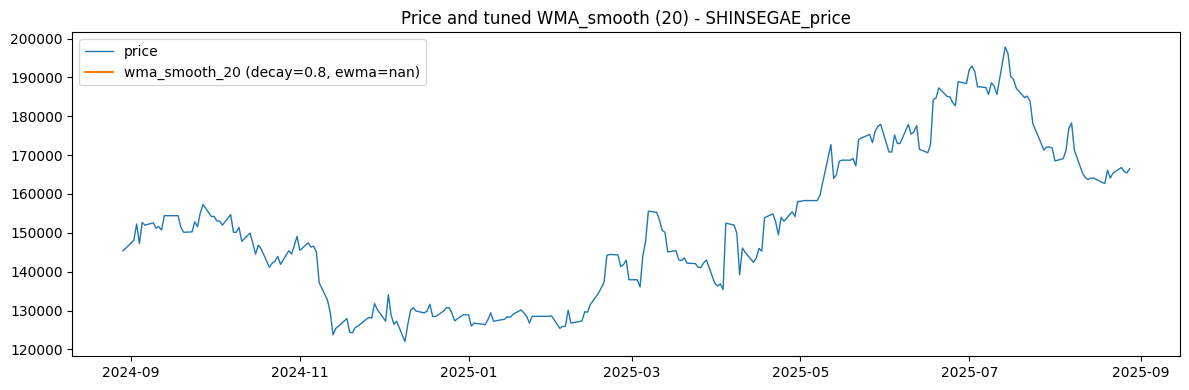

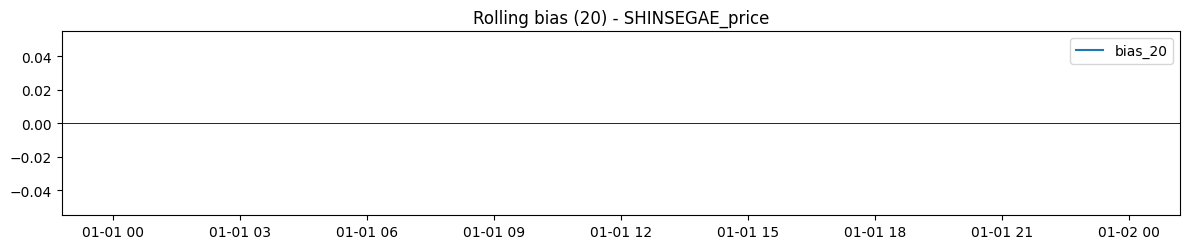

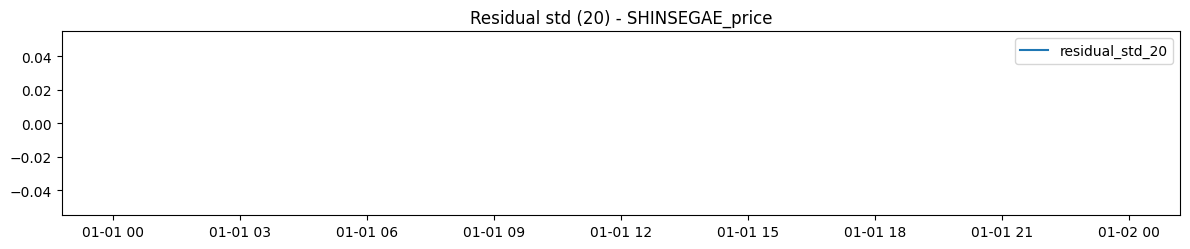

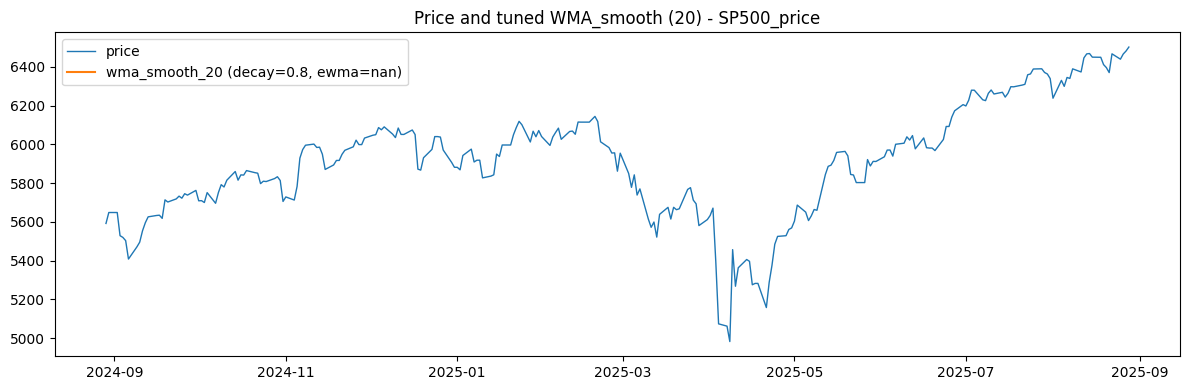

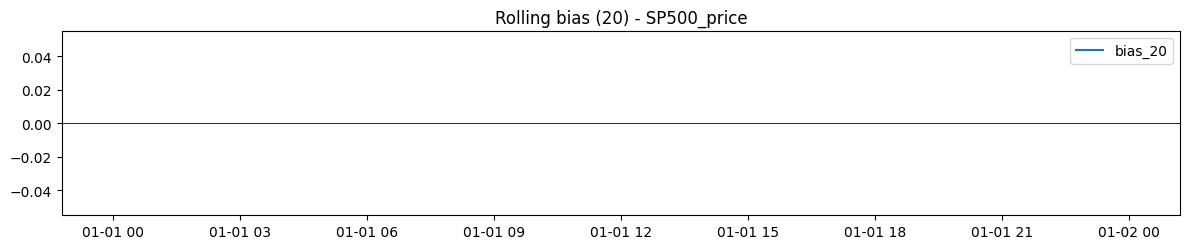

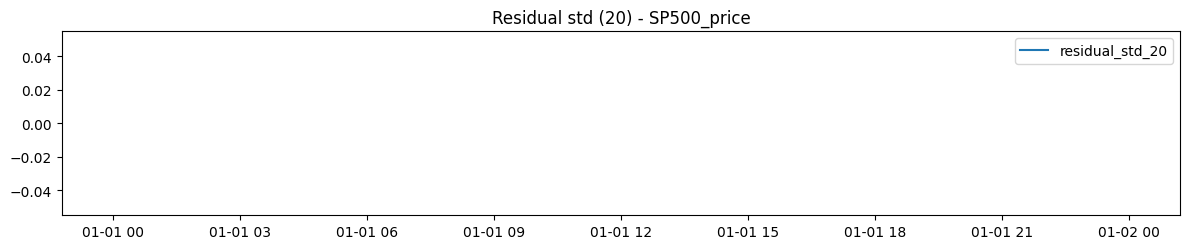

Saved plots to: /mnt/data/strategy_outputs
Saved tuning CSVs: /mnt/data/strategy_outputs/tune_shinsegae.csv /mnt/data/strategy_outputs/tune_sp500.csv
Shinsegae best params: {'decay': 0.8, 'ewma': nan, 'trend_m': 0.09600316707452358, 'resid_m': 3235.980584926192, 'roll_m': 4891.544276476821, 'bias_m': 1915.577512327695, 'score': 1.3670490716463679e-05}
SP500 best params: {'decay': 0.8, 'ewma': nan, 'trend_m': 0.10792353664000398, 'resid_m': 53.55922192789648, 'roll_m': 76.51139802889291, 'bias_m': 29.271159587070905, 'score': 0.0009609883224884637}


In [31]:
# shin_sp_plots_with_tuning.py
# 실행: 이 파일을 실행하면 /mnt/data/price_df.csv 읽고 그래프들을 /mnt/data/strategy_outputs 에 저장합니다.
# 필요: pandas, numpy, scikit-learn, scipy, matplotlib
# pip install pandas numpy scikit-learn scipy matplotlib

import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

CSV = "price_df.csv"
OUT = "/mnt/data/strategy_outputs"
os.makedirs(OUT, exist_ok=True)

# -----------------------
# 유틸: weighted MA, EWMA, rolling slope
# -----------------------
def weighted_ma(series, window, decay=0.95):
    vals = series.values
    n = len(vals)
    out = np.full(n, np.nan)
    if window <= 0:
        return pd.Series(out, index=series.index)
    for i in range(window-1, n):
        wv = vals[i-window+1:i+1]
        k = np.arange(window-1, -1, -1)
        w = decay ** k
        if np.isnan(wv).any():
            out[i] = np.nan
        else:
            out[i] = (wv * w).sum() / w.sum()
    return pd.Series(out, index=series.index)

def ewma(series, span):
    return series.ewm(span=span, adjust=False).mean() if span is not None else series

def rolling_slope(series, window):
    if window <= 1:
        return pd.Series(np.nan, index=series.index)
    n = len(series)
    slopes = np.full(n, np.nan)
    X = np.arange(window).reshape(-1,1)
    lr = LinearRegression()
    vals = series.values
    for i in range(window-1, n):
        y = vals[i-window+1:i+1]
        if np.isnan(y).any():
            continue
        lr.fit(X, y.reshape(-1,1))
        slopes[i] = float(lr.coef_[0])
    return pd.Series(slopes, index=series.index)

# -----------------------
# 데이터 로드 및 컬럼 자동 탐지
# -----------------------
df = pd.read_csv(CSV)

# 날짜 컬럼이 있으면 인덱스로 설정
for c in df.columns:
    if c.lower() in ('date','datetime','time','timestamp'):
        try:
            df[c] = pd.to_datetime(df[c], errors='coerce')
            df = df.set_index(c).sort_index()
            break
        except Exception:
            pass

def find_col(df, candidates):
    for cand in candidates:
        if cand in df.columns:
            return cand
    for name in df.columns:
        if any(k in name.lower() for k in candidates):
            return name
    return None

shin_cands = ['SHINSEGAE_price','shinsegae','shinseg','SHINSEGAE']
sp_cands = ['SP500_price','sp500','SP500','s&p','snp500']

shin_col = find_col(df, shin_cands)
sp_col   = find_col(df, sp_cands)

numcols = list(df.select_dtypes(include=[np.number]).columns)
if shin_col is None and len(numcols) >= 1: shin_col = numcols[0]
if sp_col is None and len(numcols) >= 2: sp_col = numcols[1] if numcols[0]==shin_col else numcols[0]
if shin_col is None or sp_col is None:
    raise ValueError("신세계 또는 S&P500 컬럼을 찾을 수 없습니다. CSV 컬럼명을 확인하세요.")

price_shin = df[shin_col].astype(float).copy().sort_index()
price_sp   = df[sp_col].astype(float).copy().sort_index()

print(f"Using columns -> Shinsegae: {shin_col}, SP500: {sp_col} (rows: {len(df)})")

# -----------------------
# 튜닝 함수: window=20 기준 (decay x ewma_span)
# -----------------------
def compute_metrics(series, window=20, decay=0.92, ewma_span=None):
    wma = weighted_ma(series, window=window, decay=decay)
    wma_s = ewma(wma, span=ewma_span)
    roll_std = series.rolling(window=window).std()
    residual = series - wma_s
    residual_std = residual.rolling(window=window).std()
    bias = residual.rolling(window=window).mean()
    slope = rolling_slope(wma_s, window=window)
    trend_strength = slope / (roll_std + 1e-12)
    return {
        'wma_s': wma_s, 'bias': bias, 'residual_std': residual_std, 'roll_std': roll_std,
        'bias_abs_median': float(bias.abs().median(skipna=True)),
        'resid_std_median': float(residual_std.median(skipna=True)),
        'roll_std_median': float(roll_std.median(skipna=True)),
        'trend_strength_median': float(trend_strength.abs().median(skipna=True)),
        'slope_median': float(slope.median(skipna=True))
    }

def tune_grid(series, window=20, decays=[0.8,0.9,0.92,0.95,0.98], ewma_spans=[None,3,5,8], w_var=0.5, w_bias=0.7):
    rows=[]
    for d in decays:
        for s in ewma_spans:
            m = compute_metrics(series, window=window, decay=d, ewma_span=s)
            trend_m = m['trend_strength_median']; resid = m['resid_std_median']; roll = m['roll_std_median']; bias = m['bias_abs_median']
            score = (trend_m) / (resid + w_var*roll + w_bias*bias + 1e-12)
            rows.append({'decay':d, 'ewma':s, 'trend_m':trend_m, 'resid_m':resid, 'roll_m':roll, 'bias_m':bias, 'score':score})
    df = pd.DataFrame(rows).sort_values('score', ascending=False).reset_index(drop=True)
    return df

# -----------------------
# Shinsegae 튜닝 & 최적 파라미터 적용
# -----------------------
tune_shin = tune_grid(price_shin, window=20)
best_shin = tune_shin.iloc[0]
print("Shinsegae best params:", best_shin.to_dict())
metrics_shin = compute_metrics(price_shin, window=20, decay=best_shin['decay'], ewma_span=best_shin['ewma'])

# SP500 튜닝 & 최적 파라미터 적용 (동일 방식)
tune_sp = tune_grid(price_sp, window=20)
best_sp = tune_sp.iloc[0]
print("SP500 best params:", best_sp.to_dict())
metrics_sp = compute_metrics(price_sp, window=20, decay=best_sp['decay'], ewma_span=best_sp['ewma'])

# 저장: 튜닝 결과 CSV
tune_shin.to_csv(os.path.join(OUT, "tune_shinsegae.csv"), index=False)
tune_sp.to_csv(os.path.join(OUT, "tune_sp500.csv"), index=False)

# -----------------------
# Plot 스타일(신세계처럼 큰 플롯 포함)
# -----------------------
# 1) Shinsegae: large price + tuned WMA_smooth(20)
plt.figure(figsize=(12,4))
plt.plot(price_shin.index, price_shin, label='price', linewidth=1)
plt.plot(metrics_shin['wma_s'].index, metrics_shin['wma_s'], label=f"wma_smooth_20 (decay={best_shin['decay']}, ewma={best_shin['ewma']})", linewidth=1.5)
plt.legend()
plt.title(f'Price and tuned WMA_smooth (20) - {shin_col}')
plt.tight_layout()
png1 = os.path.join(OUT, f"tuned_wma_shinsegae_20.png")
plt.savefig(png1, dpi=150)
plt.show()

# 2) Shinsegae: rolling bias (20)
plt.figure(figsize=(12,2.6))
plt.plot(metrics_shin['bias'].index, metrics_shin['bias'], label='bias_20')
plt.axhline(0, color='k', linewidth=0.6)
plt.legend()
plt.title(f'Rolling bias (20) - {shin_col}')
plt.tight_layout()
png2 = os.path.join(OUT, f"bias_shinsegae_20.png")
plt.savefig(png2, dpi=120)
plt.show()

# 3) Shinsegae: residual std (20)
plt.figure(figsize=(12,2.6))
plt.plot(metrics_shin['residual_std'].index, metrics_shin['residual_std'], label='residual_std_20')
plt.legend()
plt.title(f'Residual std (20) - {shin_col}')
plt.tight_layout()
png3 = os.path.join(OUT, f"residstd_shinsegae_20.png")
plt.savefig(png3, dpi=120)
plt.show()

# -----------------------
# SP500 plots (same style)
# -----------------------
plt.figure(figsize=(12,4))
plt.plot(price_sp.index, price_sp, label='price', linewidth=1)
plt.plot(metrics_sp['wma_s'].index, metrics_sp['wma_s'], label=f"wma_smooth_20 (decay={best_sp['decay']}, ewma={best_sp['ewma']})", linewidth=1.5)
plt.legend()
plt.title(f'Price and tuned WMA_smooth (20) - {sp_col}')
plt.tight_layout()
png4 = os.path.join(OUT, f"tuned_wma_sp500_20.png")
plt.savefig(png4, dpi=150)
plt.show()

plt.figure(figsize=(12,2.6))
plt.plot(metrics_sp['bias'].index, metrics_sp['bias'], label='bias_20')
plt.axhline(0, color='k', linewidth=0.6)
plt.legend()
plt.title(f'Rolling bias (20) - {sp_col}')
plt.tight_layout()
png5 = os.path.join(OUT, f"bias_sp500_20.png")
plt.savefig(png5, dpi=120)
plt.show()

plt.figure(figsize=(12,2.6))
plt.plot(metrics_sp['residual_std'].index, metrics_sp['residual_std'], label='residual_std_20')
plt.legend()
plt.title(f'Residual std (20) - {sp_col}')
plt.tight_layout()
png6 = os.path.join(OUT, f"residstd_sp500_20.png")
plt.savefig(png6, dpi=120)
plt.show()


# -----------------------
# 저장 및 요약
# -----------------------
print("Saved plots to:", OUT)
print("Saved tuning CSVs:", os.path.join(OUT, "tune_shinsegae.csv"), os.path.join(OUT, "tune_sp500.csv"))
print("Shinsegae best params:", best_shin.to_dict())
print("SP500 best params:", best_sp.to_dict())


Shinsegae sample: date
2024-08-29    145401.906250
2024-08-30    145983.515625
2024-09-02    148116.078125
2024-09-03    152284.265625
2024-09-04    147243.671875
Name: SHINSEGAE_price, dtype: float64
SP500 sample: date
2024-08-29    5591.959961
2024-08-30    5648.399902
2024-09-02    5648.399902
2024-09-03    5528.930176
2024-09-04    5520.069824
Name: SP500_price, dtype: float64
Shinsegae bias non-null: 223  SP bias non-null: 223


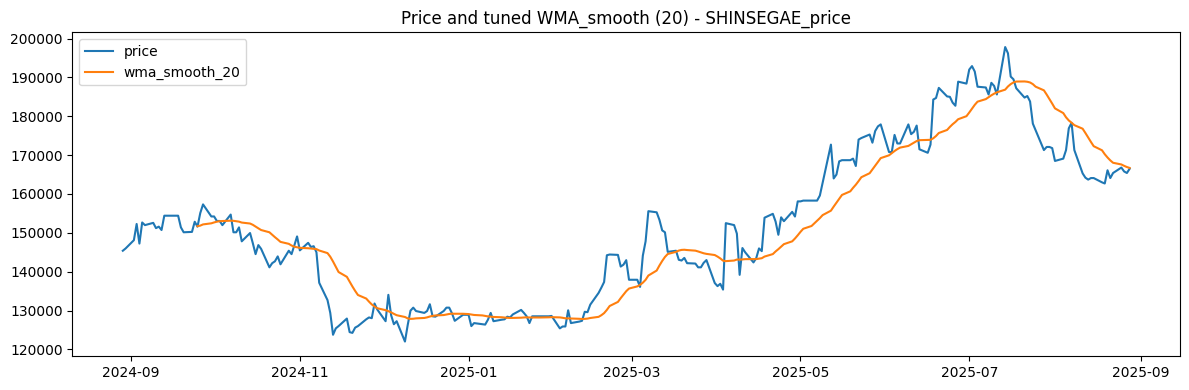

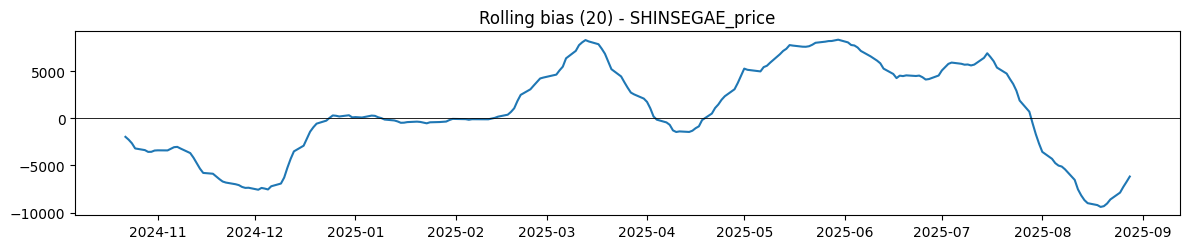

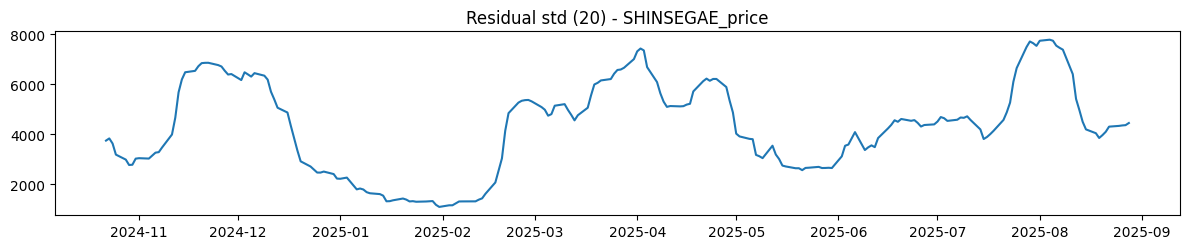

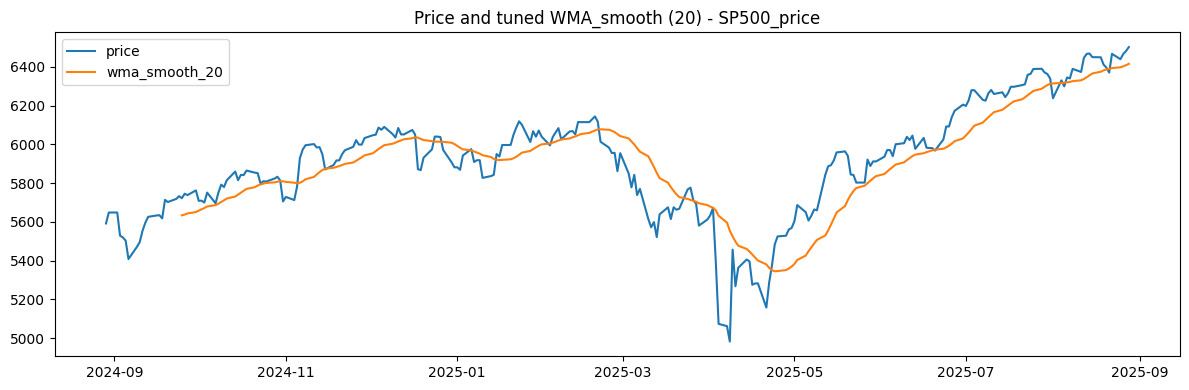

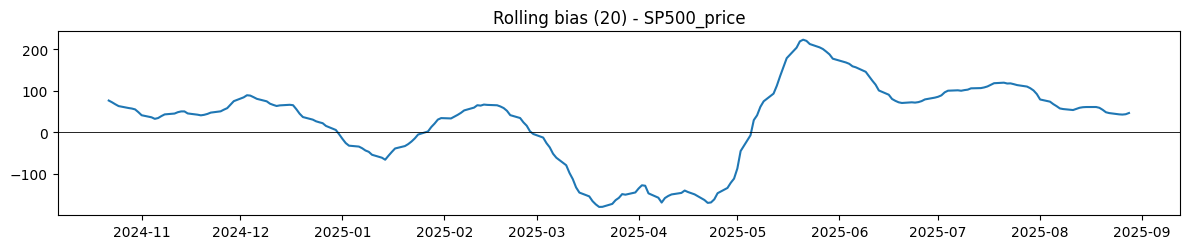

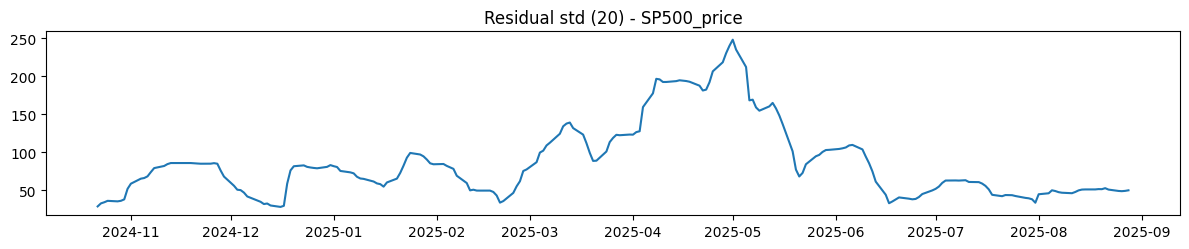

Saved forced plots to /mnt/data/strategy_outputs_forced


In [34]:
# force_price_columns_and_plot.py
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

CSV = "price_df.csv"
OUT = "/mnt/data/strategy_outputs_forced"
os.makedirs(OUT, exist_ok=True)

df = pd.read_csv(CSV)

# 날짜 있으면 인덱스로
for c in df.columns:
    if c.lower() in ('date','datetime','time','timestamp'):
        try:
            df[c] = pd.to_datetime(df[c], errors='coerce')
            df = df.set_index(c).sort_index()
            break
        except Exception:
            pass

# --- 여기서 강제 지정 (네 파일에 맞춰 필요하면 이름 바꿔) ---
shin_col = 'SHINSEGAE_price'   # <-- 강제로 이걸 price로 사용
sp_col   = 'SP500_price'       # <-- 강제로 이걸 price로 사용

# 유효성 체크
for col in (shin_col, sp_col):
    if col not in df.columns:
        raise ValueError(f"{col} 컬럼을 찾을 수 없습니다. CSV의 컬럼명을 확인하세요.")

price_shin = df[shin_col].astype(float).copy().sort_index()
price_sp   = df[sp_col].astype(float).copy().sort_index()

# 간단한 WMA/ewma 함수 (원래 코드에서 따옴)
def weighted_ma(series, window, decay=0.92):
    vals = series.values; n = len(vals); out = np.full(n, np.nan)
    for i in range(window-1, n):
        wv = vals[i-window+1:i+1]; k = np.arange(window-1, -1, -1); w = decay ** k
        if np.isnan(wv).any(): out[i] = np.nan
        else: out[i] = (wv * w).sum() / w.sum()
    return pd.Series(out, index=series.index)

def ewma(series, span):
    return series.ewm(span=span, adjust=False).mean() if span is not None else series

def rolling_slope(series, window):
    if window <= 1: return pd.Series(np.nan, index=series.index)
    n = len(series); slopes = np.full(n, np.nan); X = np.arange(window).reshape(-1,1); lr = LinearRegression()
    vals = series.values
    for i in range(window-1, n):
        y = vals[i-window+1:i+1]
        if np.isnan(y).any(): continue
        lr.fit(X, y.reshape(-1,1)); slopes[i] = float(lr.coef_[0])
    return pd.Series(slopes, index=series.index)

def compute_metrics(series, window=20, decay=0.92, ewma_span=5):
    wma = weighted_ma(series, window=window, decay=decay)
    wma_s = ewma(wma, span=ewma_span)
    roll_std = series.rolling(window=window).std()
    residual = series - wma_s
    residual_std = residual.rolling(window=window).std()
    bias = residual.rolling(window=window).mean()
    slope = rolling_slope(wma_s, window=window)
    return {'wma_s': wma_s, 'bias': bias, 'residual_std': residual_std, 'roll_std': roll_std}

metrics_shin = compute_metrics(price_shin, window=20, decay=0.92, ewma_span=5)
metrics_sp   = compute_metrics(price_sp,   window=20, decay=0.92, ewma_span=5)

# 진단 출력 (확인)
print("Shinsegae sample:", price_shin.head())
print("SP500 sample:", price_sp.head())
print("Shinsegae bias non-null:", metrics_shin['bias'].count(), " SP bias non-null:", metrics_sp['bias'].count())

# 플롯 저장 (신세계처럼)
plt.figure(figsize=(12,4))
plt.plot(price_shin.index, price_shin, label='price')
plt.plot(metrics_shin['wma_s'].index, metrics_shin['wma_s'], label='wma_smooth_20')
plt.title('Price and tuned WMA_smooth (20) - SHINSEGAE_price')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT, "shin_price_wma20_forced.png"), dpi=150); plt.show()

plt.figure(figsize=(12,2.6))
plt.plot(metrics_shin['bias'].index, metrics_shin['bias'], label='bias_20'); plt.axhline(0,color='k',linewidth=0.6)
plt.title('Rolling bias (20) - SHINSEGAE_price'); plt.tight_layout()
plt.savefig(os.path.join(OUT, "shin_bias20_forced.png"), dpi=120); plt.show()

plt.figure(figsize=(12,2.6))
plt.plot(metrics_shin['residual_std'].index, metrics_shin['residual_std'], label='residual_std_20')
plt.title('Residual std (20) - SHINSEGAE_price'); plt.tight_layout()
plt.savefig(os.path.join(OUT, "shin_residstd20_forced.png"), dpi=120); plt.show()

# 동일하게 SP500 플롯
plt.figure(figsize=(12,4))
plt.plot(price_sp.index, price_sp, label='price')
plt.plot(metrics_sp['wma_s'].index, metrics_sp['wma_s'], label='wma_smooth_20')
plt.title('Price and tuned WMA_smooth (20) - SP500_price')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT, "sp_price_wma20_forced.png"), dpi=150); plt.show()

plt.figure(figsize=(12,2.6))
plt.plot(metrics_sp['bias'].index, metrics_sp['bias'], label='bias_20'); plt.axhline(0,color='k',linewidth=0.6)
plt.title('Rolling bias (20) - SP500_price'); plt.tight_layout()
plt.savefig(os.path.join(OUT, "sp_bias20_forced.png"), dpi=120); plt.show()

plt.figure(figsize=(12,2.6))
plt.plot(metrics_sp['residual_std'].index, metrics_sp['residual_std'], label='residual_std_20')
plt.title('Residual std (20) - SP500_price'); plt.tight_layout()
plt.savefig(os.path.join(OUT, "sp_residstd20_forced.png"), dpi=120); plt.show()

print("Saved forced plots to", OUT)
